<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/15_minerva_CPC-UCI-downstream_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/15_minerva_CPC-UCI-downstream_task.ipynb)

# Using Pretrained Backbones on the Downstream Task

This notebook demonstrates how to load pretrained backbones and apply them to a time-series-based downstream task.
Specifically, it walks you through the process of loading a Convolution + GRU backbone pretrained in the tutorial `13_minerva_CPC-UCI-backbone_pretrain.ipynb`, and using it for the Human Activity Recognition (HAR) task on the UCI-HAR dataset.

## 1. Introduction

### 1.1 Objective

The primary goal of this tutorial is to demonstrate how to load and use pretrained backbones to tackle the downstream task.
Additionally, we will compare the performance of downstream models using two types of backbones:

* From Scratch – randomly initialized, i.e., with no pretraining; and

* CPC Pretrained – pretrained using the CPC self-supervised approach.

### 1.2 What we will cover

We will begin by setting up the dataloader for the downstream task.
Then, we will discuss how to build the model for the downstream task.
Next, we will build and train multiple models using from scratch and pretrained backbones.
Finally, we will evaluate their performance on the test dataset.

| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Basic Setup**](#sec_2) | Import the necessary modules (PyTorch and PyTorch Lightning), and define the key variables that control the training process.  |
| [**3. Setting Up the Data Module**](#sec_3) | Set up the data module for the training and evaluation processes. |
| [**4. Combining the Backbone and the Prediction Head**](#sec_4) | Develop code to combine the backbone with prediction heads to construct a supervised machine learning model for solving the downstream task. |
| [**5. Training the Models**](#sec_5) | Build and train several models. |
| [**6. Evaluating the models**](#sec_6) | Evaluate the trained models on the test set. |
| [**7. Exercises**](#sec_7) | Suggested Exercises. |

### 1.3 Where can you get help?

In addition to discussing with your colleagues or the course professor, you might also consider:

* Minerva: check the [Minerva docs](https://discovery-unicamp.github.io/Minerva/).

* Lightning: check the [Lightning documentation](https://lightning.ai/docs/overview/getting-started) and research or post Lightning related question on the [PyTorch Lightning forum](https://lightning.ai/forums/).

* PyTorch: check the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and research or post PyTorch related question on the [PyTorch developer forums](https://discuss.pytorch.org/).

## <a id="sec_2">2. Basic Setup</a>

### 2.1 Setting the main variables

The following variables influence the execution time of this notebook.
You may want to adjust them if you are not using high-performance hardware (e.g., fast GPUs):

* `n_epochs`: Specifies the maximum number of epochs to train each model.

* `n_version`: Determines how many versions of each model will be trained. Training multiple versions helps assess the impact of randomness on model performance.

* `DL_BATCH_SIZE`: Sets the batch size used during training.

* `DL_NUM_WORKERS`: Defines the number of parallel threads/processes the dataloader uses to prefetch and preprocess data during training.

* `output_csv_filename`: Specifies the name of the CSV file where evaluation results (accuracies of each model) will be recorded.


In [1]:
## General configuration variables

# Maximum number of epochs to train the downstream model
n_epochs = 20

# Number of model versions to train. Each model configuration will be trained n_versions times.
n_versions = 5

# Train dataloader parameters
DL_BATCH_SIZE=64
DL_NUM_WORKERS=8

# Output statistics
output_csv_filename = "15_minerva_CPC-UCI-downstream_task_results.csv"

### 2.2 Installing Lightining and Minerva modules

The code below attempts to import Minerva and installs it if it is not already available.
Since Minerva depends on the Lightning module, Lightning will also be installed automatically when Minerva is installed.

In [2]:
try:
    import minerva
except:
    try:
        #Try to install it and import again
        print("[INFO]: Could not import the minerva module. Trying to install it!")
        !pip install -q minerva-ml
        import minerva
        print("[INFO]: It looks like minerva was successfully imported!")
    except:
        raise Exception("[ERROR] Couldn't find the minerva module ... \n" +
                        "Please, install it before running the notebook.\n"+
                        "You might want to install the modules listed at requirements.txt\n" +
                        "To do so, run: \"pip install -r requirements.txt\"")

### 2.3 Importing basic modules

Let's import the basic modules, such as lightning, torch, minerva, and other utility modules.

In [3]:
# Import PyTorch
import torch

# Import torchvision
import torchvision

# Import lightning
import lightning

# Import minerva
import minerva

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"Lightning version: {lightning.__version__}")
#print(f"Minerva version: {M.__version__}") ## TODO

# Import matplotlib for visualization
import matplotlib.pyplot as plt

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
Lightning version: 2.5.1


## <a id="sec_3">3. Setting up the Dataset</a>

We will use the Daghar benchmark as the downstream task, focusing specifically on the UCI split of the dataset.

### 3.1 Download and instantiate the train, val and test datasets

We will download a version of the Daghar dataset available on my website.
The following code block downloads and extracts selected Daghar subsets into the `data/daghar/` directory.

You can choose which subsets to download by commenting or uncommenting the entries in the `daghar_subsets` variable.
For now, we will download only the UCI split.

In [4]:
import os

# Change the following code to select which subsets to download.
daghar_subsets = [
    ("UCI", "daghar-uci.zip"),                         # ~12 MB
    #("MotionSense", "daghar-motionsense.zip"),         # ~32 MB
    #("KuHar", "daghar-kuhar.zip"),                     #  ~6 MB
    #("WISDM", "daghar-wisdm.zip"),                     # ~40 MB
    #("RealWorld_thigh", "daghar-realworld_thigh.zip"), # ~48 MB
    #("RealWorld_waist", "daghar-realworld_waist.zip")  # ~48 MB
]

# For each one of the subsets selected in previous command
for subset_name, filename in daghar_subsets:

    if not os.path.exists(filename):
        # Download the zip file
        print(f"Downloading {subset_name}")
        import urllib.request
        url = f"https://www.ic.unicamp.br/~edson/disciplinas/mo810/2025-1s/{filename}"
        urllib.request.urlretrieve(url, filename)

    if not os.path.exists(f"data/daghar/{subset_name}"):
        # Unzip the file contents
        print(f"Extracting {subset_name}")
        import zipfile
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('.')

Next, we load the train, validation, and test splits from the UCI subset.
To accomplish this, we use the `DagharDataset` class, which is included as part of the downloaded Daghar dataset.

In [5]:
from data.daghar.dataset import DagharDataset
# Downstream datasets

datasets = {}

datasets["UCI"] = {}

datasets["UCI"]["train"] = DagharDataset(
    csv_file_path="./data/daghar/UCI/train.csv",
    features_as_channels=True,
    cast_to="float32",
)

datasets["UCI"]["validation"] = DagharDataset(
    csv_file_path="./data/daghar/UCI/validation.csv",
    features_as_channels=True,
    cast_to="float32",
)

datasets["UCI"]["test"] = DagharDataset(
    csv_file_path="./data/daghar/UCI/test.csv",
    features_as_channels=True,
    cast_to="float32",
)

class_names = datasets["UCI"]["train"].classes
print(f"Daghar class names: {class_names}")

print(datasets["UCI"]["train"])
print(datasets["UCI"]["validation"])
print(datasets["UCI"]["test"])

Daghar class names: ['sit', 'stand', 'walk', 'upstairs', 'downstairs', 'run']
DagharDataset at data/daghar/UCI/train.csv (2420 samples) (features shape=(6, 60))
DagharDataset at data/daghar/UCI/validation.csv (340 samples) (features shape=(6, 60))
DagharDataset at data/daghar/UCI/test.csv (690 samples) (features shape=(6, 60))


### 3.2 Inspecting the samples

Now, let's inspect a few samples from the dataset.
We'll start by defining a function to plot the samples, and then visualize one representative sample from each class.

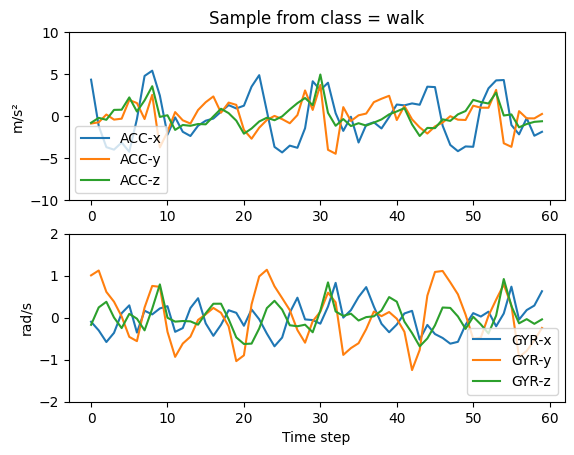

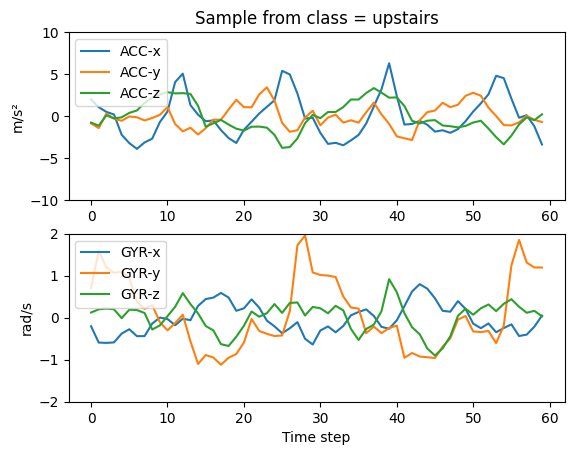

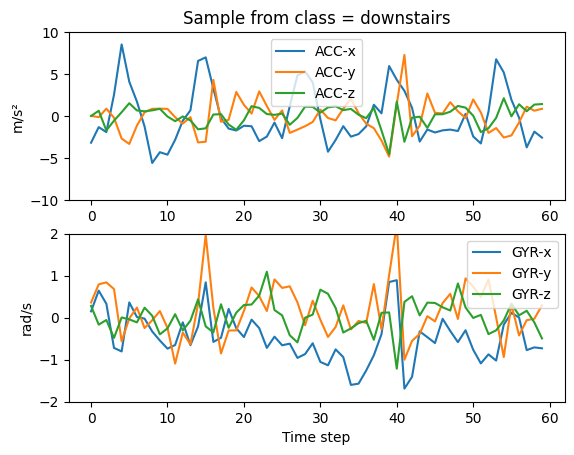

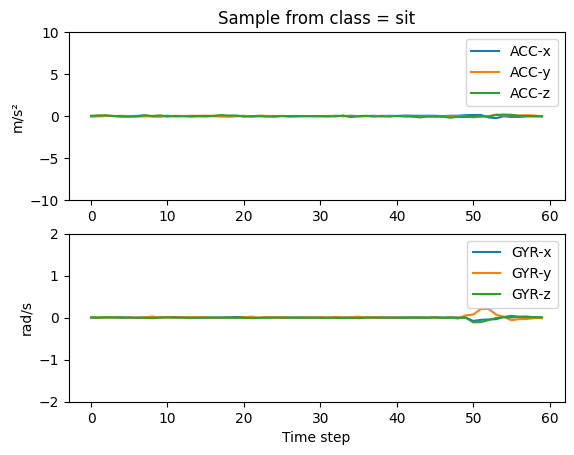

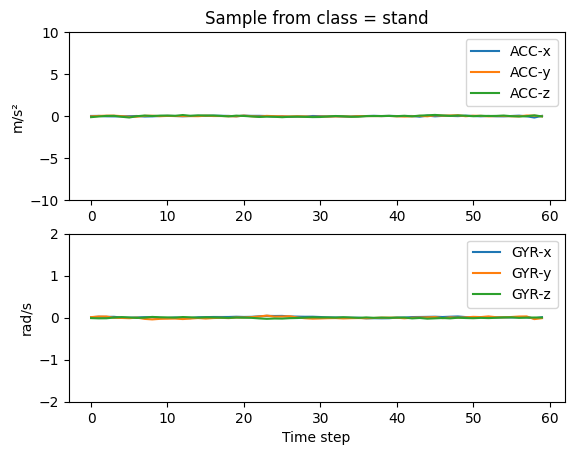

In [6]:
def plot_sample(features, label, acc_min_max=None, gyr_min_max=None):
    plt.subplot(2, 1, 1)
    plt.title(f"Sample from class = {label}")
    plt.plot(features[0], label = "ACC-x")
    plt.plot(features[1], label = "ACC-y")
    plt.plot(features[2], label = "ACC-z")
    plt.ylabel("m/s²")
    if acc_min_max: plt.ylim(acc_min_max)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(features[3], label = "GYR-x")
    plt.plot(features[4], label = "GYR-y")
    plt.plot(features[5], label = "GYR-z")
    plt.ylabel("rad/s")
    plt.xlabel("Time step")
    if gyr_min_max: plt.ylim(gyr_min_max)
    plt.legend()
    plt.show()

# Lets plot one sample from each class
viewed_class = {}
for i in range(len(datasets["UCI"]["train"])):
    features, label = datasets["UCI"]["train"][i]
    if label in viewed_class: 
        continue # Skip it, it has already been shown 
    viewed_class[label] = i
    plot_sample(features,            # Sample features
                class_names[label],  # Sample label
                acc_min_max=(-10,10), 
                gyr_min_max=(-2,2))

### 3.3 Setting up the data module

Finally, we will create a Minerva data module to organize the data and set up the corresponding dataloaders.

In [7]:
from minerva.data.data_modules.base import MinervaDataModule

cpc_datamodule = MinervaDataModule(
    train_dataset=datasets["UCI"]["train"],
    val_dataset=datasets["UCI"]["validation"],
    test_dataset=datasets["UCI"]["test"],
    num_workers=DL_NUM_WORKERS,
    batch_size=DL_BATCH_SIZE,
    name="Daghar_UCI_downstream",
)

print(cpc_datamodule)

              🆔 Daghar_UCI_downstream
└── Predict Split: test
📂 Datasets:
   ├── Train Dataset:
   │      DagharDataset at data/daghar/UCI/train.csv (2420 samples) (features shape=(6, 60))
   ├── Val Dataset:
   │      DagharDataset at data/daghar/UCI/validation.csv (340 samples) (features shape=(6, 60))
   └── Test Dataset:
          DagharDataset at data/daghar/UCI/test.csv (690 samples) (features shape=(6, 60))

🛠 **Dataloader Configurations:**
   ├── Dataloader class: <class 'torch.utils.data.dataloader.DataLoader'>
   ├── Train Dataloader Kwargs:
         ├── batch_size: 64
         ├── num_workers: 8
         ├── shuffle: true
         ├── drop_last: false
   ├── Val Dataloader Kwargs:
         ├── batch_size: 64
         ├── num_workers: 8
         ├── shuffle: false
         ├── drop_last: false
   └── Test Dataloader Kwargs:
         ├── batch_size: 64
         ├── num_workers: 8
         ├── shuffle: false
         ├── drop_last: false


## <a id="sec_4">4. Combining the Backbone and the Prediction Head</a>

In this section, we will develop the code to build a model for the downstream task.

Specifically, we will create functions to load pretrained backbones from checkpoint files and combine them with a prediction head to form a supervised model.

### 4.1 Loading a pretrained backbone

As we already discussed how to load pretrained backbones in tutorial `14_minerva_CPC-UCI-latent_space_vis.ipynb`, we will simply copy and paste the code here.


In [8]:
from minerva.models.nets.cpc_networks import Convolutional1DEncoder, HARCPCAutoregressive, Genc_Gar

def build_encoder():
    # Instantiate a 1D convolutional encoder for multi-channel time series input
    return Convolutional1DEncoder(input_size=6, kernel_size=3)

def build_autoregressor():
    # Create a unidirectional GRU-based autoregressive model for sequence modeling
    return HARCPCAutoregressive(
        input_size=128, hidden_size=256, batch_first=True, bidirectional=False
    )

def generate_backbone():
    """
    Return a Genc_Gar backbone (encoder + autoregressor) without pretrained weights.
    Used for training models from scratch on downstream tasks.
    """
    g_enc = build_encoder()
    g_ar = build_autoregressor()
    return Genc_Gar(g_enc=g_enc, g_ar=g_ar)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from minerva.models.ssl.cpc import CPC

def load_pretrained_backbone(ckpt_filename=None, use_checkpoint=True):
    g_enc = build_encoder()
    g_ar = build_autoregressor()

    if use_checkpoint and ckpt_filename is not None:
        pretext_model = CPC.load_from_checkpoint(
            ckpt_filename,
            g_enc=g_enc,
            g_ar=g_ar,
            prediction_head_in_channels=256,
            prediction_head_out_channels=128
        )
        return pretext_model.g_enc, pretext_model.g_ar

    return g_enc, g_ar

### 4.2 Building a SimpleSupervisedModel model from a given backbone

Now, we will combine the pretrained backbone with a prediction head to construct a model for the downstream task.

To achieve this, we will create a simple MLP prediction head and attach it to the pretrained backbone using Minerva's `SimpleSupervisedModel` class.

#### 4.2.1 Generating the prediction head

We will use a simple MLP consisting of two linear layers with a ReLU activation in between.
The code below defines this architecture using `torch.nn.Sequential()`.

In [10]:
def generate_pred_head(backbone_out_dim=256, hidden_dim=128):
    return torch.nn.Sequential(
        torch.nn.Linear(backbone_out_dim, hidden_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_dim, len(class_names))
        )

#### 4.2.2 Building the SimpleSupervisedModel

When constructing the `SimpleSupervisedModel`, we will use `CrossEntropyLoss()` as the loss function and include accuracy metrics to monitor the model's performance on both the training and test sets.

In [11]:
from minerva.models.nets.base import SimpleSupervisedModel
from torchmetrics import Accuracy

# Build a simple supervised model
def build_SimpleSupervisedModel(backbone):
  return SimpleSupervisedModel(
    backbone=backbone,
    fc=generate_pred_head(),
    loss_fn=torch.nn.CrossEntropyLoss(),
    train_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    val_metrics  ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    test_metrics ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
  )

## <a id="sec_5">5. Training the models</a>

Now, we will build and train several models to evaluate the impact of pretraining on the performance of a downstream task.
Specifically, we will compare models that use pretrained backbones with those that use randomly initialized (untrained) backbones—referred to as from scratch models.

Let’s begin by creating a dictionary to store all the models.

In [12]:
models = {}

### 5.1 Downloading Minerva CPC checkpoint

We will use checkpoints generated by CPC in the tutorial `13_minerva_CPC-UCI-backbone_pretrain.ipynb`.

If you did not save your own checkpoints, you can download a pre-generated checkpoints that I have made available.
For convenience, the code below will automatically download and extract these checkpoints.

In [13]:
import os
filename = '13_minerva_CPC_UCI_backbone_pretraining-1-20.zip'

if not os.path.exists(filename):
    # Download the zip file with checkpoints
    import urllib.request
    url = 'https://www.ic.unicamp.br/~edson/disciplinas/mo810/2025-1s/13_minerva_CPC_UCI_backbone_pretraining-1-20.zip'
    urllib.request.urlretrieve(url, filename)

if not os.path.exists("logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/"):
    # Unzip the checkpoint file
    import zipfile
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

### 5.2 Building the models

The code below constructs multiple versions (`n_versions`) of the models to be evaluated.

* The `From_Scratch` model uses a randomly initialized (untrained) backbone.

* The `Pretrained_CPC_{epoch_number}` models use backbones initialized with weights loaded from checkpoints generated during CPC training. The `epoch_number` indicates the epoch number.

In [14]:
import glob

# Let's set the seeds for reproducibility
lightning.seed_everything(42)

# For each version id
for version in range(n_versions):

    # Search for the checkpoints on the following folder
    cpc_ckpt_files = glob.glob("logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/epoch=*.ckpt")

    # For each checkpoint file.
    for i, ckpt_filename in enumerate(cpc_ckpt_files):
        g_enc, g_ar = load_pretrained_backbone(ckpt_filename)
        backbone_cpc = Genc_Gar(g_enc=g_enc, g_ar=g_ar)

        # Extract basename and epoch info from checkpoint path
        info = ckpt_filename.split("/") 
        checkpoint_filename = info[6]
        epoch_info = checkpoint_filename.split("-")[0]
        epoch_number = int(epoch_info.split("=")[1])

        models[f"Pretrained_CPC_{epoch_number:03d}/ft_{n_epochs}_ep/v_{version}"] = {
            "backbone": backbone_cpc,
            "model": build_SimpleSupervisedModel(backbone_cpc),
            "nepochs": n_epochs,
            "version": version,
            "epoch number": epoch_number
        }

    # -- Add the from scratch model --
    backbone = generate_backbone()
    models[f"From_Scratch/ft_{n_epochs}_ep/v_{version}"] = {
        "backbone": backbone,
        "model": build_SimpleSupervisedModel(backbone),
        "nepochs": n_epochs,
        "version": version
    }

# Log dos modelos incluídos
print("== The following models were included ==")
for i, k in enumerate(models.keys()):
    print(f"{i:3d} {k}")

Seed set to 42


== The following models were included ==
  0 Pretrained_CPC_011/ft_20_ep/v_0
  1 Pretrained_CPC_003/ft_20_ep/v_0
  2 Pretrained_CPC_019/ft_20_ep/v_0
  3 Pretrained_CPC_015/ft_20_ep/v_0
  4 Pretrained_CPC_007/ft_20_ep/v_0
  5 From_Scratch/ft_20_ep/v_0
  6 Pretrained_CPC_011/ft_20_ep/v_1
  7 Pretrained_CPC_003/ft_20_ep/v_1
  8 Pretrained_CPC_019/ft_20_ep/v_1
  9 Pretrained_CPC_015/ft_20_ep/v_1
 10 Pretrained_CPC_007/ft_20_ep/v_1
 11 From_Scratch/ft_20_ep/v_1
 12 Pretrained_CPC_011/ft_20_ep/v_2
 13 Pretrained_CPC_003/ft_20_ep/v_2
 14 Pretrained_CPC_019/ft_20_ep/v_2
 15 Pretrained_CPC_015/ft_20_ep/v_2
 16 Pretrained_CPC_007/ft_20_ep/v_2
 17 From_Scratch/ft_20_ep/v_2
 18 Pretrained_CPC_011/ft_20_ep/v_3
 19 Pretrained_CPC_003/ft_20_ep/v_3
 20 Pretrained_CPC_019/ft_20_ep/v_3
 21 Pretrained_CPC_015/ft_20_ep/v_3
 22 Pretrained_CPC_007/ft_20_ep/v_3
 23 From_Scratch/ft_20_ep/v_3
 24 Pretrained_CPC_011/ft_20_ep/v_4
 25 Pretrained_CPC_003/ft_20_ep/v_4
 26 Pretrained_CPC_019/ft_20_ep/v_4
 27 Pretrai

### 5.3 Training the models

As in previous Lightning/Minerva tutorials, we will use the Lightning `Trainer()` class to train our models.
We will configure a `TensorBoardLogger()` to save logs in the `logs/15_minerva_CPC_UCI/Downstream/` directory, and a `ModelCheckpoint()` callback to save the best model based on validation loss.

For convenience, the code below also reports training statistics—such as the number of models already trained, how many are left, the elapsed training time, and an estimate of the remaining time to completion.

In [15]:
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# Register stats
from timeit import default_timer as timer
n_configs = len(models)
n_configs_trained = 0
start_time = timer()

for model_name, model_info in models.items():
    print("***********************************")
    print(f" Training model {model_name}")
    print("***********************************")
    logger = TensorBoardLogger(save_dir=f"logs/15_minerva_CPC_UCI/Downstream/", name=model_name)
    trainer = Trainer(max_epochs=model_info["nepochs"], benchmark=True,
                      log_every_n_steps=8, logger=logger,
                      callbacks=[ModelCheckpoint(monitor="val_loss", mode="min")])
    trainer.fit(model_info["model"], cpc_datamodule)

    # Compute and display training statistics
    elapsed = timer() - start_time
    n_configs_trained += 1
    avg = elapsed / n_configs_trained
    print("-----------------------------------")
    print(f"Training stats")
    print(f"  - Avg time to train models: {avg:.2f} seconds ")
    est_total = avg * n_configs
    est_remaining = est_total - elapsed
    print(f"  - Total # models  : {n_configs} model(s)")
    print(f"  - Models trained  : {n_configs_trained} model(s) in {elapsed:.2f} seconds")
    print(f"  - Remaining models: {n_configs-n_configs_trained} model(s). {est_remaining} s remaining (Estimative)")
    print(f"  - Total time      : {est_total} seconds (estimate: avg * # models)")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         M

***********************************
 Training model Pretrained_CPC_011/ft_20_ep/v_0
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 27.74it/s, v_num=0, val_loss=0.126, val_accuracy=0.947, train_loss=0.0996, train_accuracy=0.958]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.31it/s, v_num=0, val_loss=0.126, val_accuracy=0.947, train_loss=0.0996, train_accuracy=0.958]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 29.63 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 1 model(s) in 29.63 seconds
  - Remaining models: 29 model(s). 859.1523055005819 s remaining (Estimative)
  - Total time      : 888.7782470695674 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_003/ft_20_ep/v_0
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 32.94it/s, v_num=0, val_loss=0.186, val_accuracy=0.903, train_loss=0.173, train_accuracy=0.922]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 32.83it/s, v_num=0, val_loss=0.186, val_accuracy=0.903, train_loss=0.173, train_accuracy=0.922]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



-----------------------------------
Training stats
  - Avg time to train models: 28.90 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 2 model(s) in 57.80 seconds
  - Remaining models: 28 model(s). 809.2086617150344 s remaining (Estimative)
  - Total time      : 867.0092804089654 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_019/ft_20_ep/v_0
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 27.79it/s, v_num=0, val_loss=0.149, val_accuracy=0.935, train_loss=0.0749, train_accuracy=0.971]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 27.69it/s, v_num=0, val_loss=0.149, val_accuracy=0.935, train_loss=0.0749, train_accuracy=0.971]
-----------------------------------
Training stats
  - Avg time to train models: 28.71 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 3 model(s) in 86.13 seconds
  - Remaining models: 27 model(s). 775.1564630535431 s remaining (Estimative)
  - Total time      : 861.2849589483812 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_015/ft_20_ep/v_0
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.50it/s, v_num=0, val_loss=0.125, val_accuracy=0.953, train_loss=0.0675, train_accuracy=0.975]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.39it/s, v_num=0, val_loss=0.125, val_accuracy=0.953, train_loss=0.0675, train_accuracy=0.975]
-----------------------------------
Training stats
  - Avg time to train models: 28.72 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 4 model(s) in 114.90 seconds
  - Remaining models: 26 model(s). 746.8250513550593 s remaining (Estimative)
  - Total time      : 861.7212131019915 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_007/ft_20_ep/v_0
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 24.74it/s, v_num=0, val_loss=0.170, val_accuracy=0.932, train_loss=0.137, train_accuracy=0.945]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 24.67it/s, v_num=0, val_loss=0.170, val_accuracy=0.932, train_loss=0.137, train_accuracy=0.945]
-----------------------------------
Training stats
  - Avg time to train models: 28.94 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 5 model(s) in 144.69 seconds
  - Remaining models: 25 model(s). 723.4576139843557 s remaining (Estimative)
  - Total time      : 868.1491367812268 seconds (estimate: avg * # models)
***********************************
 Training model From_Scratch/ft_20_ep/v_0
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 30.70it/s, v_num=0, val_loss=0.168, val_accuracy=0.938, train_loss=0.152, train_accuracy=0.937]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 27.70it/s, v_num=0, val_loss=0.168, val_accuracy=0.938, train_loss=0.152, train_accuracy=0.937]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.88 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 6 model(s) in 173.29 seconds
  - Remaining models: 24 model(s). 693.1554638752714 s remaining (Estimative)
  - Total time      : 866.4443298440892 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_011/ft_20_ep/v_1
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 31.98it/s, v_num=0, val_loss=0.132, val_accuracy=0.935, train_loss=0.127, train_accuracy=0.942]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.96it/s, v_num=0, val_loss=0.132, val_accuracy=0.935, train_loss=0.127, train_accuracy=0.942]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.74 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 7 model(s) in 201.15 seconds
  - Remaining models: 23 model(s). 660.9156533698219 s remaining (Estimative)
  - Total time      : 862.0638956997677 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_003/ft_20_ep/v_1
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.04it/s, v_num=0, val_loss=0.242, val_accuracy=0.871, train_loss=0.257, train_accuracy=0.866]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.47it/s, v_num=0, val_loss=0.242, val_accuracy=0.871, train_loss=0.257, train_accuracy=0.866]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.50 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 8 model(s) in 227.97 seconds
  - Remaining models: 22 model(s). 626.907688027015 s remaining (Estimative)
  - Total time      : 854.8741200368386 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_019/ft_20_ep/v_1
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.48it/s, v_num=0, val_loss=0.142, val_accuracy=0.935, train_loss=0.085, train_accuracy=0.969] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.39it/s, v_num=0, val_loss=0.142, val_accuracy=0.935, train_loss=0.085, train_accuracy=0.969]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode



-----------------------------------
Training stats
  - Avg time to train models: 28.46 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 9 model(s) in 256.17 seconds
  - Remaining models: 21 model(s). 597.7399415070347 s remaining (Estimative)
  - Total time      : 853.9142021529067 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_015/ft_20_ep/v_1
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.39it/s, v_num=0, val_loss=0.151, val_accuracy=0.941, train_loss=0.128, train_accuracy=0.952] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.29it/s, v_num=0, val_loss=0.151, val_accuracy=0.941, train_loss=0.128, train_accuracy=0.952]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



-----------------------------------
Training stats
  - Avg time to train models: 28.47 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 10 model(s) in 284.70 seconds
  - Remaining models: 20 model(s). 569.4092660080642 s remaining (Estimative)
  - Total time      : 854.1138990120962 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_007/ft_20_ep/v_1
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.85it/s, v_num=0, val_loss=0.187, val_accuracy=0.926, train_loss=0.159, train_accuracy=0.936]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 23.71it/s, v_num=0, val_loss=0.187, val_accuracy=0.926, train_loss=0.159, train_accuracy=0.936]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.50 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 11 model(s) in 313.48 seconds
  - Remaining models: 19 model(s). 541.4732086924752 s remaining (Estimative)
  - Total time      : 854.9576979354871 seconds (estimate: avg * # models)
***********************************
 Training model From_Scratch/ft_20_ep/v_1
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 29.55it/s, v_num=0, val_loss=0.226, val_accuracy=0.894, train_loss=0.201, train_accuracy=0.906]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 29.43it/s, v_num=0, val_loss=0.226, val_accuracy=0.894, train_loss=0.201, train_accuracy=0.906]
-----------------------------------
Training stats
  - Avg time to train models: 28.60 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 12 model(s) in 343.24 seconds
  - Remaining models: 18 model(s). 514.8580866178963 s remaining (Estimative)
  - Total time      : 858.0968110298272 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_011/ft_20_ep/v_2
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:00<00:00, 38.05it/s, v_num=0, val_loss=0.114, val_accuracy=0.953, train_loss=0.116, train_accuracy=0.952]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 33.59it/s, v_num=0, val_loss=0.114, val_accuracy=0.953, train_loss=0.116, train_accuracy=0.952]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.68 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 13 model(s) in 372.81 seconds
  - Remaining models: 17 model(s). 487.52365080530467 s remaining (Estimative)
  - Total time      : 860.3358543623024 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_003/ft_20_ep/v_2
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 29.97it/s, v_num=0, val_loss=0.249, val_accuracy=0.868, train_loss=0.227, train_accuracy=0.893]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 27.24it/s, v_num=0, val_loss=0.249, val_accuracy=0.868, train_loss=0.227, train_accuracy=0.893]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.69 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 14 model(s) in 401.72 seconds
  - Remaining models: 16 model(s). 459.11284493708183 s remaining (Estimative)
  - Total time      : 860.8365842570284 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_019/ft_20_ep/v_2
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 24.52it/s, v_num=0, val_loss=0.141, val_accuracy=0.947, train_loss=0.0982, train_accuracy=0.961]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 24.44it/s, v_num=0, val_loss=0.141, val_accuracy=0.947, train_loss=0.0982, train_accuracy=0.961]
-----------------------------------
Training stats
  - Avg time to train models: 28.71 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 15 model(s) in 430.69 seconds
  - Remaining models: 15 model(s). 430.6851638238877 s remaining (Estimative)
  - Total time      : 861.3703276477754 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_015/ft_20_ep/v_2
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.62it/s, v_num=0, val_loss=0.248, val_accuracy=0.874, train_loss=0.193, train_accuracy=0.914]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.51it/s, v_num=0, val_loss=0.248, val_accuracy=0.874, train_loss=0.193, train_accuracy=0.914]
-----------------------------------
Training stats
  - Avg time to train models: 28.72 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 16 model(s) in 459.54 seconds
  - Remaining models: 14 model(s). 402.093283568247 s remaining (Estimative)
  - Total time      : 861.6284647891007 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_007/ft_20_ep/v_2
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.56it/s, v_num=0, val_loss=0.158, val_accuracy=0.915, train_loss=0.124, train_accuracy=0.948]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 23.56it/s, v_num=0, val_loss=0.158, val_accuracy=0.915, train_loss=0.124, train_accuracy=0.948]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.74 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 17 model(s) in 488.57 seconds
  - Remaining models: 13 model(s). 373.6144260678934 s remaining (Estimative)
  - Total time      : 862.1871370797539 seconds (estimate: avg * # models)
***********************************
 Training model From_Scratch/ft_20_ep/v_2
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 31.74it/s, v_num=0, val_loss=0.283, val_accuracy=0.818, train_loss=0.253, train_accuracy=0.853]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 31.59it/s, v_num=0, val_loss=0.283, val_accuracy=0.818, train_loss=0.253, train_accuracy=0.853]
-----------------------------------
Training stats
  - Avg time to train models: 28.57 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 18 model(s) in 514.26 seconds
  - Remaining models: 12 model(s). 342.8390971293363 s remaining (Estimative)
  - Total time      : 857.0977428233407 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_011/ft_20_ep/v_3
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:00<00:00, 38.40it/s, v_num=0, val_loss=0.126, val_accuracy=0.938, train_loss=0.121, train_accuracy=0.949]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 34.12it/s, v_num=0, val_loss=0.126, val_accuracy=0.938, train_loss=0.121, train_accuracy=0.949]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.30 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 19 model(s) in 537.67 seconds
  - Remaining models: 11 model(s). 311.2842643742915 s remaining (Estimative)
  - Total time      : 848.9570846571587 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_003/ft_20_ep/v_3
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 29.82it/s, v_num=0, val_loss=0.319, val_accuracy=0.812, train_loss=0.280, train_accuracy=0.826]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 29.71it/s, v_num=0, val_loss=0.319, val_accuracy=0.812, train_loss=0.280, train_accuracy=0.826]
-----------------------------------
Training stats
  - Avg time to train models: 28.15 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 20 model(s) in 563.07 seconds
  - Remaining models: 10 model(s). 281.5356313379016 s remaining (Estimative)
  - Total time      : 844.6068940137047 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_019/ft_20_ep/v_3
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 30.45it/s, v_num=0, val_loss=0.150, val_accuracy=0.947, train_loss=0.0648, train_accuracy=0.974]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 30.35it/s, v_num=0, val_loss=0.150, val_accuracy=0.947, train_loss=0.0648, train_accuracy=0.974]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode



-----------------------------------
Training stats
  - Avg time to train models: 28.15 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 21 model(s) in 591.19 seconds
  - Remaining models: 9 model(s). 253.36676048956406 s remaining (Estimative)
  - Total time      : 844.555868298547 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_015/ft_20_ep/v_3
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 29.02it/s, v_num=0, val_loss=0.124, val_accuracy=0.944, train_loss=0.0816, train_accuracy=0.967]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.92it/s, v_num=0, val_loss=0.124, val_accuracy=0.944, train_loss=0.0816, train_accuracy=0.967]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



-----------------------------------
Training stats
  - Avg time to train models: 28.16 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 22 model(s) in 619.41 seconds
  - Remaining models: 8 model(s). 225.24023282400924 s remaining (Estimative)
  - Total time      : 844.6508730900347 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_007/ft_20_ep/v_3
***********************************



  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 30.16it/s, v_num=0, val_loss=0.279, val_accuracy=0.815, train_loss=0.269, train_accuracy=0.831]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 27.33it/s, v_num=0, val_loss=0.279, val_accuracy=0.815, train_loss=0.269, train_accuracy=0.831]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.16 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 23 model(s) in 647.61 seconds
  - Remaining models: 7 model(s). 197.09833655822217 s remaining (Estimative)
  - Total time      : 844.7071566780949 seconds (estimate: avg * # models)
***********************************
 Training model From_Scratch/ft_20_ep/v_3
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 30.40it/s, v_num=0, val_loss=0.200, val_accuracy=0.912, train_loss=0.173, train_accuracy=0.926]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 30.27it/s, v_num=0, val_loss=0.200, val_accuracy=0.912, train_loss=0.173, train_accuracy=0.926]
-----------------------------------
Training stats
  - Avg time to train models: 28.16 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 24 model(s) in 675.85 seconds
  - Remaining models: 6 model(s). 168.96183692547493 s remaining (Estimative)
  - Total time      : 844.8091846273746 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_011/ft_20_ep/v_4
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.80it/s, v_num=0, val_loss=0.156, val_accuracy=0.938, train_loss=0.101, train_accuracy=0.958]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.71it/s, v_num=0, val_loss=0.156, val_accuracy=0.938, train_loss=0.101, train_accuracy=0.958]
-----------------------------------
Training stats
  - Avg time to train models: 28.18 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 25 model(s) in 704.43 seconds
  - Remaining models: 5 model(s). 140.88616560879166 s remaining (Estimative)
  - Total time      : 845.3169936527498 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_003/ft_20_ep/v_4
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.26it/s, v_num=0, val_loss=0.269, val_accuracy=0.838, train_loss=0.245, train_accuracy=0.864]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.14it/s, v_num=0, val_loss=0.269, val_accuracy=0.838, train_loss=0.245, train_accuracy=0.864]
-----------------------------------
Training stats
  - Avg time to train models: 28.22 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 26 model(s) in 733.70 seconds
  - Remaining models: 4 model(s). 112.87698574475223 s remaining (Estimative)
  - Total time      : 846.577393085642 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_019/ft_20_ep/v_4
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 30.16it/s, v_num=0, val_loss=0.165, val_accuracy=0.926, train_loss=0.105, train_accuracy=0.960]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.91it/s, v_num=0, val_loss=0.165, val_accuracy=0.926, train_loss=0.105, train_accuracy=0.960]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



-----------------------------------
Training stats
  - Avg time to train models: 28.27 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 27 model(s) in 763.39 seconds
  - Remaining models: 3 model(s). 84.82137332176274 s remaining (Estimative)
  - Total time      : 848.2137332176272 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_015/ft_20_ep/v_4
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 29.41it/s, v_num=0, val_loss=0.0996, val_accuracy=0.965, train_loss=0.0734, train_accuracy=0.971]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 26.85it/s, v_num=0, val_loss=0.0996, val_accuracy=0.965, train_loss=0.0734, train_accuracy=0.971]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 28.42 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 28 model(s) in 795.73 seconds
  - Remaining models: 2 model(s). 56.837508832852905 s remaining (Estimative)
  - Total time      : 852.5626324927933 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_CPC_007/ft_20_ep/v_4
***********************************
Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.93it/s, v_num=0, val_loss=0.161, val_accuracy=0.929, train_loss=0.126, train_accuracy=0.951]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 23.22it/s, v_num=0, val_loss=0.161, val_accuracy=0.929, train_loss=0.126, train_accuracy=0.951]
-----------------------------------
Training stats
  - Avg time to train models: 28.44 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 29 model(s) in 824.62 seconds
  - Remaining models: 1 model(s). 28.43518522037357 s remaining (Estimative)
  - Total time      : 853.0555566112062 seconds (estimate: avg * # models)
***********************************
 Training model From_Scratch/ft_20_ep/v_4
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Genc_Gar         | 722 K  | train
1 | fc       | Sequential       | 33.7 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
756 K     Trainable params
0         Non-trainable params
756 K     Total params
3.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 28.52it/s, v_num=0, val_loss=0.272, val_accuracy=0.841, train_loss=0.267, train_accuracy=0.841]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 38/38 [00:01<00:00, 25.80it/s, v_num=0, val_loss=0.272, val_accuracy=0.841, train_loss=0.267, train_accuracy=0.841]
-----------------------------------
Training stats
  - Avg time to train models: 28.48 seconds 
  - Total # models  : 30 model(s)
  - Models trained  : 30 model(s) in 854.44 seconds
  - Remaining models: 0 model(s). 0.0 s remaining (Estimative)
  - Total time      : 854.4417677368037 seconds (estimate: avg * # models)


## <a id="sec_6">6. Evaluating the models on the test set</a>

Now, let's evaluate the models we trained using the test set.
First, we will compute the test accuracy for each model.
Then, we will visualize the results in a plot.

### 6.1 Loading the model weights and evaluating their peformance

First, let's list all checkpoint files generated by the training process.

In [16]:
import glob

model_ckpt_files = glob.glob(f"logs/15_minerva_CPC_UCI/Downstream/*/ft_{n_epochs}_ep/v_*/version_*/checkpoints/*")

print(f"** {len(model_ckpt_files)} model_ckpt_files **")
for i, f in enumerate(model_ckpt_files):
    print(f" {i:3d} {f}")

** 30 model_ckpt_files **
   0 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_4/version_0/checkpoints/epoch=16-step=646.ckpt
   1 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_3/version_0/checkpoints/epoch=19-step=760.ckpt
   2 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_0/version_0/checkpoints/epoch=19-step=760.ckpt
   3 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_2/version_0/checkpoints/epoch=19-step=760.ckpt
   4 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=760.ckpt
   5 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_4/version_0/checkpoints/epoch=19-step=760.ckpt
   6 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_3/version_0/checkpoints/epoch=18-step=722.ckpt
   7 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_0/version_0/checkpoints/epoch=18-step=722.ckpt
   8 logs/15_minerva_CPC_UCI/Downstrea

Now, for each checkpoint, we will load its weights into the `SimpleSupervisedModel` used for the downstream task and evaluate its performance on the test set.

During this process, the model's accuracy will be recorded in the CSV file specified by the `output_csv_filename` variable.

In [17]:
from lightning import Trainer

trainer = Trainer()

# Write output CSV file header
with open(output_csv_filename, "w") as f:
    f.write(f"Model name,Version,Accuracy,ckpt_filename\n")

# For each checkpoint file.
for i, ckpt_filename in enumerate(model_ckpt_files):
    print(f"==== {i:3d} {ckpt_filename} ====")

    # Model basename
    info = ckpt_filename.split("/")
    basename = info[3]
    version = info[5] + "-" + info[6]
    print(f"* Filename: {ckpt_filename}\n* Basename: {basename}\n* Version:{version}")

    # Load the model
    model = SimpleSupervisedModel.load_from_checkpoint(ckpt_filename,
                                        backbone=generate_backbone(),
                                        fc = generate_pred_head(),
                                        loss_fn=torch.nn.CrossEntropyLoss(),
                                        test_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))})

    # Compute the accuracy on test set.
    test_result = trainer.test(model, cpc_datamodule)
    acc = test_result[0]["test_accuracy"] * 100

    # Append result to CSV file.
    with open(output_csv_filename, "a") as f:
        f.write(f"{basename},{version},{acc},{ckpt_filename}\n")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


====   0 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_4/version_0/checkpoints/epoch=16-step=646.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_4/version_0/checkpoints/epoch=16-step=646.ckpt
* Basename: Pretrained_CPC_011
* Version:v_4-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 98.13it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9420289993286133     │
│         test_loss         │    0.15191107988357544    │
└───────────────────────────┴───────────────────────────┘

====   1 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_3/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_3/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_011
* Version:v_3-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 105.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9550724625587463     │
│         test_loss         │    0.14417731761932373    │
└───────────────────────────┴───────────────────────────┘

====   2 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_0/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_0/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_011
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 133.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9434782862663269     │
│         test_loss         │    0.17102769017219543    │
└───────────────────────────┴───────────────────────────┘

====   3 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_2/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_2/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_011
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 107.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9637681245803833     │
│         test_loss         │    0.10636821389198303    │
└───────────────────────────┴───────────────────────────┘

====   4 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_011/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_011
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 135.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9492753744125366     │
│         test_loss         │    0.1443338394165039     │
└───────────────────────────┴───────────────────────────┘

====   5 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_4/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_4/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_015
* Version:v_4-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 135.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9753623008728027     │
│         test_loss         │    0.09109939634799957    │
└───────────────────────────┴───────────────────────────┘

====   6 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_3/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_3/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: Pretrained_CPC_015
* Version:v_3-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 129.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9681159257888794     │
│         test_loss         │    0.10449069738388062    │
└───────────────────────────┴───────────────────────────┘

====   7 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_0/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_0/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: Pretrained_CPC_015
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 134.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9753623008728027     │
│         test_loss         │    0.0961187407374382     │
└───────────────────────────┴───────────────────────────┘

====   8 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_2/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_2/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: Pretrained_CPC_015
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 111.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8768116235733032     │
│         test_loss         │    0.2856096923351288     │
└───────────────────────────┴───────────────────────────┘

====   9 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_1/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_015/ft_20_ep/v_1/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: Pretrained_CPC_015
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 114.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.960869550704956     │
│         test_loss         │    0.10427051782608032    │
└───────────────────────────┴───────────────────────────┘

====  10 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_003
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 78.36it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8463768362998962     │
│         test_loss         │    0.3189389407634735     │
└───────────────────────────┴───────────────────────────┘

====  11 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_2/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_2/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_003
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 131.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.865217387676239     │
│         test_loss         │    0.31459298729896545    │
└───────────────────────────┴───────────────────────────┘

====  12 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_0/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_0/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: Pretrained_CPC_003
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 126.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9246376752853394     │
│         test_loss         │    0.2113533765077591     │
└───────────────────────────┴───────────────────────────┘

====  13 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_4/version_0/checkpoints/epoch=17-step=684.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_4/version_0/checkpoints/epoch=17-step=684.ckpt
* Basename: Pretrained_CPC_003
* Version:v_4-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 127.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8260869383811951     │
│         test_loss         │    0.31878718733787537    │
└───────────────────────────┴───────────────────────────┘

====  14 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_3/version_0/checkpoints/epoch=14-step=570.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_003/ft_20_ep/v_3/version_0/checkpoints/epoch=14-step=570.ckpt
* Basename: Pretrained_CPC_003
* Version:v_3-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 146.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8188405632972717     │
│         test_loss         │    0.3218855857849121     │
└───────────────────────────┴───────────────────────────┘

====  15 logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_0/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_0/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: From_Scratch
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 119.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9304347634315491     │
│         test_loss         │    0.1982129067182541     │
└───────────────────────────┴───────────────────────────┘

====  16 logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_3/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_3/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: From_Scratch
* Version:v_3-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 128.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.926086962223053     │
│         test_loss         │    0.19727006554603577    │
└───────────────────────────┴───────────────────────────┘

====  17 logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_4/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_4/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: From_Scratch
* Version:v_4-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 130.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.821739137172699     │
│         test_loss         │    0.3259419798851013     │
└───────────────────────────┴───────────────────────────┘

====  18 logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_1/version_0/checkpoints/epoch=17-step=684.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_1/version_0/checkpoints/epoch=17-step=684.ckpt
* Basename: From_Scratch
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 96.69it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9188405871391296     │
│         test_loss         │    0.1906958818435669     │
└───────────────────────────┴───────────────────────────┘

====  19 logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_2/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/From_Scratch/ft_20_ep/v_2/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: From_Scratch
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 112.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8362318873405457     │
│         test_loss         │    0.31611281633377075    │
└───────────────────────────┴───────────────────────────┘

====  20 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_007
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 133.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9420289993286133     │
│         test_loss         │    0.15527036786079407    │
└───────────────────────────┴───────────────────────────┘

====  21 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_2/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_2/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_007
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 106.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9362319111824036     │
│         test_loss         │    0.18795359134674072    │
└───────────────────────────┴───────────────────────────┘

====  22 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_0/version_0/checkpoints/epoch=16-step=646.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_0/version_0/checkpoints/epoch=16-step=646.ckpt
* Basename: Pretrained_CPC_007
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 123.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9333333373069763     │
│         test_loss         │    0.1745283007621765     │
└───────────────────────────┴───────────────────────────┘

====  23 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_3/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_3/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_007
* Version:v_3-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 148.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.813043475151062     │
│         test_loss         │    0.3178008198738098     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


====  24 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_4/version_0/checkpoints/epoch=19-step=760.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_007/ft_20_ep/v_4/version_0/checkpoints/epoch=19-step=760.ckpt
* Basename: Pretrained_CPC_007
* Version:v_4-version_0
Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 119.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9362319111824036     │
│         test_loss         │    0.1748514175415039     │
└───────────────────────────┴───────────────────────────┘

====  25 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_4/version_0/checkpoints/epoch=17-step=684.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_4/version_0/checkpoints/epoch=17-step=684.ckpt
* Basename: Pretrained_CPC_019
* Version:v_4-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 130.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9637681245803833     │
│         test_loss         │    0.1389869749546051     │
└───────────────────────────┴───────────────────────────┘

====  26 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_3/version_0/checkpoints/epoch=16-step=646.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_3/version_0/checkpoints/epoch=16-step=646.ckpt
* Basename: Pretrained_CPC_019
* Version:v_3-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 128.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9652174115180969     │
│         test_loss         │    0.09780509024858475    │
└───────────────────────────┴───────────────────────────┘

====  27 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_0/version_0/checkpoints/epoch=18-step=722.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_0/version_0/checkpoints/epoch=18-step=722.ckpt
* Basename: Pretrained_CPC_019
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 102.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.95652174949646      │
│         test_loss         │    0.17615094780921936    │
└───────────────────────────┴───────────────────────────┘

====  28 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_2/version_0/checkpoints/epoch=17-step=684.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_2/version_0/checkpoints/epoch=17-step=684.ckpt
* Basename: Pretrained_CPC_019
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 146.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9594202637672424     │
│         test_loss         │    0.1149270236492157     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


====  29 logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_1/version_0/checkpoints/epoch=14-step=570.ckpt ====
* Filename: logs/15_minerva_CPC_UCI/Downstream/Pretrained_CPC_019/ft_20_ep/v_1/version_0/checkpoints/epoch=14-step=570.ckpt
* Basename: Pretrained_CPC_019
* Version:v_1-version_0
Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 139.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9652174115180969     │
│         test_loss         │    0.11154298484325409    │
└───────────────────────────┴───────────────────────────┘

### 6.2 Plotting the results

Finally, let's visualize the results stored in the CSV file.
We will use the Pandas and Plotly libraries for data handling and interactive plotting.
To begin, we will load the CSV contents into a Pandas DataFrame.

In [18]:
import pandas as pd
df = pd.read_csv(output_csv_filename)
# Show the first entries
df.head()

,Model name,Version,Accuracy,ckpt_filename
0,Pretrained_CPC_011,v_4-version_0,94.202900,logs/15_minerva_CPC_UCI/Downstream/Pretrained_...
1,Pretrained_CPC_011,v_3-version_0,95.507246,logs/15_minerva_CPC_UCI/Downstream/Pretrained_...
2,Pretrained_CPC_011,v_0-version_0,94.347829,logs/15_minerva_CPC_UCI/Downstream/Pretrained_...
3,Pretrained_CPC_011,v_2-version_0,96.376812,logs/15_minerva_CPC_UCI/Downstream/Pretrained_...
4,Pretrained_CPC_011,v_1-version_0,94.927537,logs/15_minerva_CPC_UCI/Downstream/Pretrained_...


Note that the DataFrame is structured such that each row represents the accuracy achieved by a single model version.

The next command lists all the unique values found on the `Model name` column.

In [19]:
sorted_models = sorted(df["Model name"].unique())
sorted_models

['From_Scratch',
 'Pretrained_CPC_003',
 'Pretrained_CPC_007',
 'Pretrained_CPC_011',
 'Pretrained_CPC_015',
 'Pretrained_CPC_019']

Now, let’s visualize the results using Plotly's box plot tool.

> **Hint**: If you want to display an interactive Plotly chart, set `pio.renderers.default` to `"jupyterlab"` or `"vscode"`.
You can list the available renderers on your system by printing the `pio.renderers` variable.

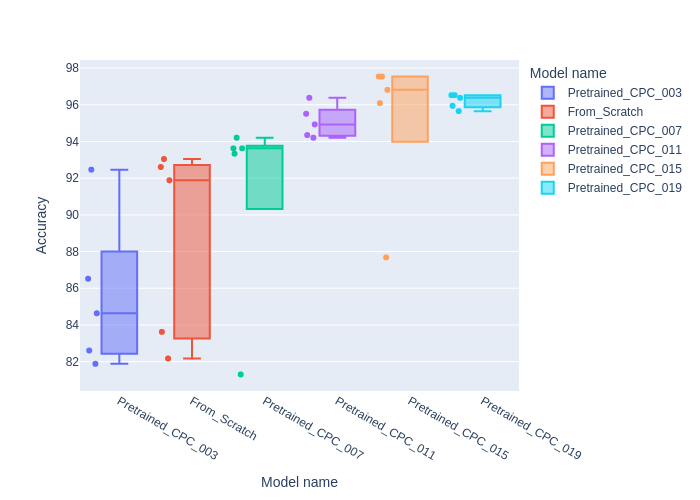

In [23]:
import plotly.express as px

# Configure the plotly renderer to use jupyterlab - you might print the
# contents of the pio.renderers variable to check for other available
# renderers (examples include: vscode, png, jpeg, pdf, ...)
import plotly.io as pio
pio.renderers.default = "png"
#pio.renderers.default = "vscode"
# print(pio.renderers)
#pio.renderers.default = "colab"

# Create and show the plot.
fig = px.box(df, x="Model name", y="Accuracy", color="Model name", points="all", category_orders={"Model name": sorted_models})
fig.show()

In [24]:
models_acc = []

# Compute average accuracy per model
for model_name, subdf in df.groupby(["Model name"]):
    acc = subdf["Accuracy"].mean()
    models_acc.append((acc,model_name[0]))

# Produce a list of strings with model basenames sorted by their accuracy.
sorted_models = [model_name for acc, model_name in sorted(models_acc)]

sorted_models


['Pretrained_CPC_003',
 'From_Scratch',
 'Pretrained_CPC_007',
 'Pretrained_CPC_011',
 'Pretrained_CPC_015',
 'Pretrained_CPC_019']

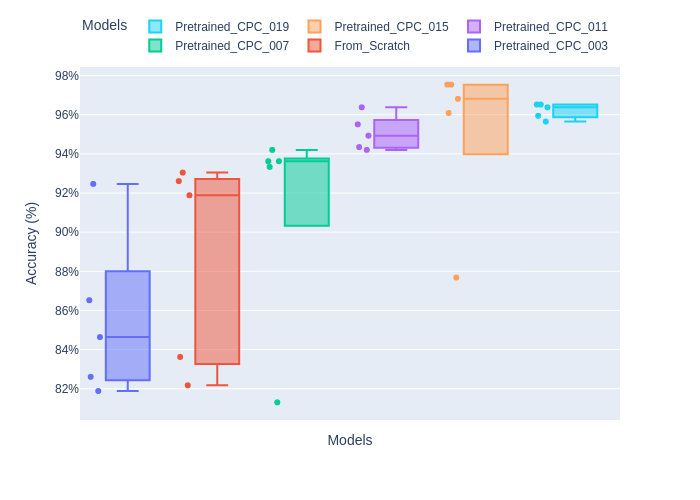

In [26]:
import plotly.express as px

# Create the plot.
fig = px.box(df, x="Model name", y="Accuracy", 
             color="Model name", points="all",
             category_orders={"Model name": sorted_models},
             labels={"Model name": "Models", "Accuracy": "Accuracy (%)"}
             )
# Hide the group legend
fig.update_xaxes(showticklabels=False)
# Format y-axis values
fig.layout.yaxis.ticksuffix = '%'
fig.update_layout(legend_traceorder="reversed")
# Format legend positioning.
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="left",
    x=0.0
))

fig.show()